# 问题定义

通过现有数据，找到一个能预测出用户生命周期价值（LTV）的模型，来指导获客的成本，避免超出回报的盲目投入

# 数据预处理

In [1]:
import pandas as pd #导入Pandas
df_sales = pd.read_csv('易速鲜花订单记录.csv') #载入数据
df_sales.head() #显示头几行数据 

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市
0,536374,21258,6/1/2020 9:09,五彩玫瑰五支装,32,10.95,15100,北京
1,536376,22114,6/1/2020 9:32,茉莉花白色25枝,48,3.45,15291,上海
2,536376,21733,6/1/2020 9:32,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海
3,536378,22386,6/1/2020 9:37,百合粉色10花苞,10,1.95,14688,北京
4,536378,85099C,6/1/2020 9:37,橙黄香槟色康乃馨,10,1.95,14688,北京


这个数据集包含订单号、产品码、消费日期、产品说明、数量（订单）、单价、用户码和城市等字段。那么，哪些字段与用户的LTV相关呢？

用户的消费金额和LTV之间存在着紧密的关联。然而，我们不能简单地将用户的消费金额视为LTV本身，因为这样的模型没有意义。

针对你提出的困惑，我们需要进行两个小调整来解决问题。

首先，我们可以考虑使用头三个月的消费金额来预测用户未来一年或两年的“价值”，而不是使用整个一年的消费金额。通过建立基于历史数据的模型后，对于新注册用户，我们只需观察他们在最初三个月内表现如何，就能够预测他们今后一到两年内总共会消费多少。如果某类App用户平均使用长度为一到两年，则该数值即代表了该用户的生命周期价值。

其次，在前面学习到了R、F、M值作为特征变量，并且避免了仅从单一维度进行建模所带来的局限性。在RMF（Recency, Frequency, Monetary）用户分组中，我们不仅可以获得消费金额信息，还能获取新近度和购买频率等指标。这些层级将非数值变量转化为数值变量，并且与用户LTV之间也存在密切相关性。

因此，在我们的模型中，可以使用头三个月的R、F、M这三个数值作为特征，即回归模型的自变量。而回归模型所要预测的因变量，即数据集的标签，就是一年的总消费额，你可以将其视为用户的LTV。

In [2]:
city = pd.get_dummies(df_sales.城市, prefix='城市')
df_sales = pd.concat([df_sales, city], axis=1)
df_sales

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,城市_上海,城市_北京,城市_广州,城市_成都,城市_深圳,城市_苏州,城市_西安
0,536374,21258,6/1/2020 9:09,五彩玫瑰五支装,32,10.95,15100,北京,0,1,0,0,0,0,0
1,536376,22114,6/1/2020 9:32,茉莉花白色25枝,48,3.45,15291,上海,1,0,0,0,0,0,0
2,536376,21733,6/1/2020 9:32,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,1,0,0,0,0,0,0
3,536378,22386,6/1/2020 9:37,百合粉色10花苞,10,1.95,14688,北京,0,1,0,0,0,0,0
4,536378,85099C,6/1/2020 9:37,橙黄香槟色康乃馨,10,1.95,14688,北京,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87175,581585,21684,6/9/2021 12:31,产品说明掩码,12,5.00,15804,深圳,0,0,0,0,1,0,0
87176,581585,22398,6/9/2021 12:31,产品说明掩码,12,499.00,15804,深圳,0,0,0,0,1,0,0
87177,581585,23328,6/9/2021 12:31,产品说明掩码,4,58.00,15804,深圳,0,0,0,0,1,0,0
87178,581585,23145,6/9/2021 12:31,产品说明掩码,12,88.90,15804,深圳,0,0,0,0,1,0,0


这段代码是用Python编程语言和pandas库来处理一个名为`df_sales`的数据框(DataFrame)，其中包含了不同城市的销售数据。这里的目标是将城市这一类别特征转化为数值特征，以便能在机器学习模型中使用。我们使用了一种称为"独热编码" (One-Hot Encoding)的方法来实现这一目标。以下是代码的逐行解释。

1. `city = pd.get_dummies(df_sales.城市, prefix='城市')`

这一行代码使用pandas库的`get_dummies`函数对城市特征进行独热编码。独热编码的目的是将类别特征(如城市名称)转化为一组二进制特征，每一个新特征表示一个城市。例如，如果有3个城市（A，B和C），对应的独热编码形式为：

- 城市A: [1, 0, 0]
- 城市B: [0, 1, 0]
- 城市C: [0, 0, 1]

在这个例子中，对于每个城市生成了一个新列，列名使用“城市_”作为前缀。

2. `df_sales = pd.concat([df_sales, city], axis=1)`

这一行代码将原始的数据框`df_sales`和独热编码后的城市数据框`city`沿着列的方向（axis=1表示横向）进行拼接。这样一来，原始数据框中的每条数据都会有独热编码城市的相关信息。

最后一行`df_sales`只是用来显示更新后的数据框。拼接后的`df_sales`数据框将包含原始的城市列，以及表示独热编码的新列。接下来，你可以将这个新的数据表用于机器学习模型的训练和预测。

---

你可能会认为用户所在的“城市”字段与其消费能力有一定关联。这个观点看起来合理，但是像“北京”、“上海”这样的文本字段不能直接输入回归模型中。如果要考虑城市信息，应该将其转换为0或1的哑变量值，并输入模型中。例如，“是否北京”（取值为0或1）， “是否上海”（取值为0或1）， “是否深圳”（取值为0或1）等等。

如此一来，特征数量就增加了很多，并且对于这个数据集而言，城市对LTV值的影响并不大。综合考虑以上因素，在这个项目中我们决定不再考虑“城市”字段。

## 整理日期格式

In [3]:
df_sales = pd.read_csv('易速鲜花订单记录.csv') #载入数据
print('日期范围（格式转化前）: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围（格式转换前）
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转换日期格式
print('日期范围（格式转化后）: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))#显示日期范围

日期范围（格式转化前）: 1/1/2021 10:11 ~ 9/9/2020 9:20
日期范围（格式转化后）: 2020-06-01 09:09:00 ~ 2021-06-09 12:31:00


这段代码主要用于载入一个名为"易速鲜花订单记录.csv"的数据文件，并处理其中的日期格式。以下是代码的逐行解释：

1. `df_sales = pd.read_csv('易速鲜花订单记录.csv')`

这行代码使用pandas库的`read_csv`函数读取一个csv文件"易速鲜花订单记录.csv"，其中包含易速鲜花的订单记录，然后将数据存储在名为`df_sales`的数据框(DataFrame)中。

2. `print('日期范围（格式转化前）: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))`

这行代码计算并打印订单数据中消费日期的范围。使用`df_sales`数据框中的'消费日期'列的最小值(`min()`)和最大值(`max()`)来确定日期范围。此时的日期尚未进行格式转换。

3. `df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期'])`

这行代码将`df_sales`数据框中'消费日期'列的数据类型转换为日期时间格式(`datetime`)，以便于后续的计算和分析。`pd.to_datetime()`是pandas库中用于转换日期时间格式的函数。

4. `print('日期范围（格式转化后）: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))`

在日期格式转换后，这行代码再次计算并打印消费日期的范围，以确保转换成功。

根据这段代码，我们现在已经成功将销售数据载入一个数据框，并进行了日期格式转换。接下来，你可以对这个数据框进行进一步的处理和分析。

In [4]:
df_sales = df_sales.loc[df_sales['消费日期'] < '2021-06-01'] #只保留整月数据
print('日期范围（删除不完整的月份）: %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max())) #显示日期范围

日期范围（删除不完整的月份）: 2020-06-01 09:09:00 ~ 2021-05-31 17:39:00


## 数据可视化

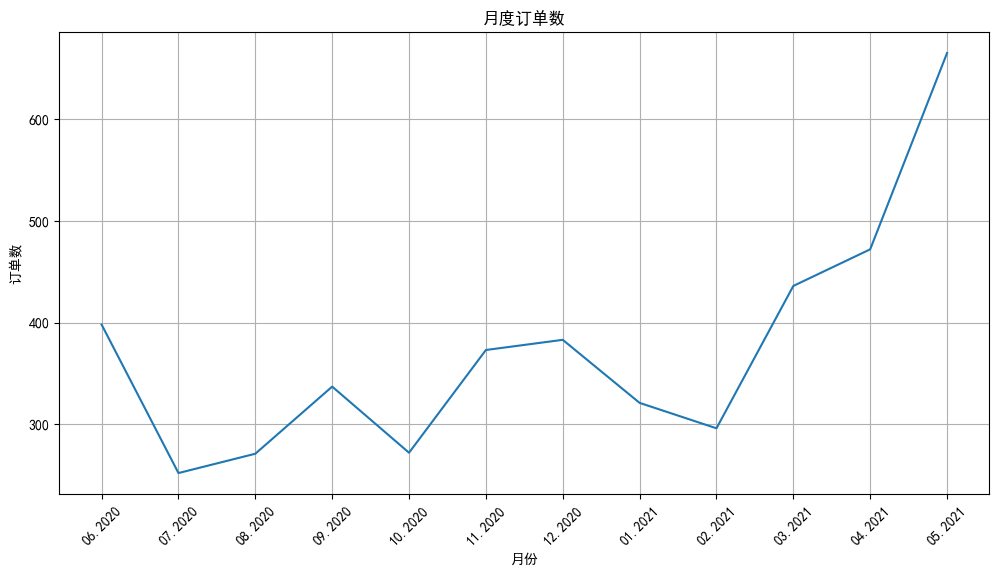

In [5]:
import matplotlib.pyplot as plt #导入Matplotlib的pyplot模块
plt.rcParams['font.family'] = ['SimHei'] #或者 ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
#构建月度的订单数的DataFrame
df_orders_monthly = df_sales.set_index('消费日期')['订单号'].resample('M').nunique()
#设定绘图的画布
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('月份') # X轴label
ax.set_ylabel('订单数') # Y轴Label
ax.set_title('月度订单数') # 图题
#设定X轴月份显示格式
plt.xticks(
    range(len(df_orders_monthly.index)), 
    [x.strftime('%m.%Y') for x in df_orders_monthly.index], 
    rotation=45)
plt.show() # 绘图

这段代码用于绘制月度订单量的折线图。这里用到了`pandas`库（用于数据处理）和`matplotlib.pyplot`库（用于绘图）。以下是代码的逐行解释：

1. `import matplotlib.pyplot as plt` 导入`matplotlib`库中的`pyplot`模块，以实现绘图功能。

2. `df_orders_monthly = df_sales.set_index('消费日期')['订单号'].resample('M').nunique()`

这行代码的目的是计算每个月的独特订单数量。首先，它将`df_sales`数据框的索引改为 '消费日期' 列，然后按照每个月('M')重新采样和计算独特订单数量（使用`nunique()`方法）。

3. `ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True, figsize=(12, 6), legend=False)`

这行代码创建一个新的数据框，其中只包含月度订单数的值。接着plot这个数据，并设定相关的属性。指定网格线`grid=True`，设置画布尺寸大小为 12x6，不显示图例`legend=False`。`ax`是一个AxesSubplot对象，用于绘制及设置图形的属性。

4. `ax.set_xlabel('月份'), ax.set_ylabel('订单数'), ax.set_title('月度订单数')`

这三行代码分别设置X轴和Y轴的标题（标签），以及整个图表的标题。

5. `plt.xticks(...)` 

这条代码用于设定X轴刻度标签，使其显示为“月-年”格式。例如：'08.2021' 代表2021年8月。`range(len(df_orders_monthly.index))`确定刻度的位置，而`[x.strftime('%m.%Y') for x in df_orders_monthly.index]`为每个刻度指定月-年格式的标签。`rotation=45`表示刻度标签逆时针旋转45度，以便于阅读。

6. `plt.show()` 这行代码用于显示绘制的折线图。

执行完成后，将绘制并显示一个月度订单数量的折线图，横轴表示月份，纵轴表示订单数量。通过这个图形，你可以分析订单数量在不同月份的变化趋势。

## 清理数据

In [6]:
df_sales = df_sales.drop_duplicates() #删除重复的数据行

In [7]:
# df_sales = df_sales.loc[df_sales['数量'] > 0] #清洗掉数量小于等于0的数据

## 特征工程

根据前面的分析，我们将使用过去三个月的R、F、M值作为特征字段，并将整个十二个月的消费金额视为LTV，作为标签字段。

### 计算总价

In [8]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价'] #计算每单的总价
df_sales.head() #显示头几行数据  

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.4
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.6
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.2
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.5
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.5


### 构建用户层级表

In [9]:
df_sales_3m = df_sales[(df_sales.消费日期 > '2020-06-01') & (df_sales.消费日期 <= '2020-08-30')] #构建仅含头三个月数据的数据集
df_sales_3m.reset_index(drop=True) #重置索引

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.40
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.60
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.20
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.50
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.50
...,...,...,...,...,...,...,...,...,...
14564,545190,22937,2020-08-29 15:32:00,产品说明掩码,6,18.00,15656,苏州,108.00
14565,545190,22722,2020-08-29 15:32:00,产品说明掩码,4,39.50,15656,苏州,158.00
14566,545190,22457,2020-08-29 15:32:00,产品说明掩码,60,3.00,15656,苏州,180.00
14567,545190,22464,2020-08-29 15:32:00,产品说明掩码,12,25.00,15656,苏州,300.00


这段代码的目的是从原始的销售数据(`df_sales`)中筛选出2020年6月1日至2020年8月30日这三个月的销售数据，并重置其索引。

1. `df_sales_3m = df_sales[(df_sales.消费日期 > '2020-06-01') & (df_sales.消费日期 <= '2020-08-30')]`

这行代码使用布尔条件筛选`df_sales`数据框中的数据。条件为消费日期大于2020年6月1日(`df_sales.消费日期 > '2020-06-01'`) 且（`&`）小于等于2020年8月30日(`df_sales.消费日期 <= '2020-08-30'`)。将筛选后的数据存储在新的数据框`df_sales_3m`中，现在`df_sales_3m`中仅包含这三个月的销售数据。

2. `df_sales_3m.reset_index(drop=True)` 

这行代码对`df_sales_3m`数据框重置索引，`drop=True`表示不保留旧的索引列。需要注意的是，这行代码实际上没有对`df_sales_3m`数据框进行修改，因为`reset_index()`函数默认是返回一个新的数据框，原始数据不受影响。要修改`df_sales_3m`的索引，需要将这行代码更改为：

`df_sales_3m = df_sales_3m.reset_index(drop=True)`

这样才会将重置后的索引数据存回到`df_sales_3m`。

现在你已经创建了一个新的数据框`df_sales_3m`，其中只包含2020年6月1日至2020年8月30日这三个月的销售数据，并且已经将其索引重新设置。这将有助于你针对这个特定时间段的数据进行进一步分析。

### 计算RFM值

In [10]:
df_user = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构
df_user.columns = ['用户码'] #设定字段名
df_user.head() #显示头几行数据
df_R_value = df_sales_3m.groupby('用户码').消费日期.max().reset_index() #找到每个用户的最近消费日期，构建df_R_value对象
df_R_value.columns = ['用户码','最近购买日期'] #设定字段名
df_R_value['R值'] = (df_R_value['最近购买日期'].max() - df_R_value['最近购买日期']).dt.days #计算最新日期与上次消费日期的天数
df_user = pd.merge(df_user, df_R_value[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_F_value = df_sales_3m.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_F_value对象
df_F_value.columns = ['用户码','F值'] #设定字段名
df_user = pd.merge(df_user, df_F_value[['用户码','F值']], on='用户码') #把消费频率(F值)整合至df_user结构
df_M_value = df_sales_3m.groupby('用户码').总价.sum().reset_index() #计算每个用户三个月消费总额，构建df_M_value对象
df_M_value.columns = ['用户码','M值'] #设定字段名
df_user = pd.merge(df_user, df_M_value, on='用户码') #把消费总额整合至df_user结构
df_user #显示用户表结构

,用户码,R值,F值,M值
0,15100,45,6,635.10
1,15291,35,35,1329.95
2,14688,6,85,1472.28
3,15311,5,715,12711.66
4,15862,89,64,354.23
...,...,...,...,...
365,15951,1,22,375.17
366,14745,1,7,240.60
367,15724,0,5,103.65
368,15874,0,5,584.35


这段代码通过对三个月的销售数据（2020年6月1日至2020年8月30日）进行处理，计算每个用户的RFM（最近购买日期、消费频率、消费金额）值，并将结果合并到一个新的数据框`df_user`中。以下是代码的逐行解释：

1. `df_user = pd.DataFrame(df_sales['用户码'].unique())`

这行代码从原始销售数据（`df_sales`）中提取唯一的用户码（即没有重复的用户编码），并以此创建一个新的单列数据框`df_user`。

2. `df_user.columns = ['用户码']`

设置新数据框的列名为“用户码”。

3. `df_user.head()`

显示`df_user`的前几行数据。

4. `df_R_value = df_sales_3m.groupby('用户码').消费日期.max().reset_index()`

根据用户码对三个月的销售数据进行分组，并找到每个用户组内的最近消费日期（取消费日期的最大值），以创建一个新的数据框`df_R_value`。

5. `df_R_value.columns = ['用户码','最近购买日期']`

设置`df_R_value`的列名。

6. `df_R_value['R值'] = (df_R_value['最近购买日期'].max() - df_R_value['最近购买日期']).dt.days`

为每个用户计算其最近购买日期距离整个数据集中的最新购买日期的天数（即R值）。

7. `df_user = pd.merge(df_user, df_R_value[['用户码','R值']], on='用户码')`

将R值合并到`df_user`数据框中（通过“用户码”列进行关联）。

8. `df_F_value = df_sales_3m.groupby('用户码').消费日期.count().reset_index()`

计算每个用户在这三个月内的消费次数（即F值，通过对每个用户的消费日期进行计数）并创建一个新的数据框`df_F_value`。

9. `df_F_value.columns = ['用户码','F值']`

设置`df_F_value`的列名。

10. `df_user = pd.merge(df_user, df_F_value[['用户码','F值']], on='用户码')`

将F值合并到`df_user`数据框中（通过“用户码”列进行关联）。

11. `df_M_value = df_sales_3m.groupby('用户码').总价.sum().reset_index()`

计算每个用户在这三个月内的消费总金额（即M值，通过对每个用户的“总价”列求和）并创建一个新的数据框`df_M_value`。

12. `df_M_value.columns = ['用户码','M值']`

设置`df_M_value`的列名。

13. `df_user = pd.merge(df_user, df_M_value, on='用户码')`

将M值合并到`df_user`数据框中（通过“用户码”列进行关联）。

14. `df_user`

显示整个`df_user`数据框（包含用户码、R值、F值和M值）。

现在，你已经成功计算并构建了一个包含每个用户RFM值的数据框`df_user`。这个数据框可以作为进一步分析的基础，例如对客户进行细分、预测客户流失可能性或客户终身价值等。

### 计算LTV值

标签是需要预测或判断的对象。机器学习通过已知信息来预测未知情况，通过训练数据集寻找规律并发现特征与标签之间的关联。因此，下一步需要将LTV值添加到df_user_LTV中，以使数据集完整。

In [11]:
df_user_1y = df_sales.groupby('用户码')['总价'].sum().reset_index() #计算每个用户整年消费总额，构建df_user_1y对象
df_user_1y.columns = ['用户码','年度LTV'] #设定字段名
df_user_1y.head() #显示头几行数据
df_LTV = pd.merge(df_user, df_user_1y, on='用户码', how='left') #构建整体LTV训练数据集
df_LTV #显示df_LTV

,用户码,R值,F值,M值,年度LTV
0,15100,45,6,635.10,635.10
1,15291,35,35,1329.95,4596.51
2,14688,6,85,1472.28,4449.48
3,15311,5,715,12711.66,58218.04
4,15862,89,64,354.23,659.73
...,...,...,...,...,...
365,15951,1,22,375.17,375.17
366,14745,1,7,240.60,1167.16
367,15724,0,5,103.65,212.30
368,15874,0,5,584.35,4330.67


这段代码通过计算每个用户一整年的消费总额，来创建每个用户的年度LTV（终身价值）数据，并将其添加至之前计算得到的RFM值数据框`df_user`中。以下是代码的逐行解释：

1. `df_user_1y = df_sales.groupby('用户码')['总价'].sum().reset_index()`

根据用户码对原始销售数据（`df_sales`）进行分组，并计算每个用户在一年内的消费总额（通过对每个用户的“总价”列求和）。然后创建一个新的数据框`df_user_1y`。

2. `df_user_1y.columns = ['用户码','年度LTV']`

设置`df_user_1y`的列名。

3. `df_user_1y.head()`

打印出`df_user_1y`数据框的前几行数据。

4. `df_LTV = pd.merge(df_user, df_user_1y, on='用户码', how='left')`

使用`pd.merge()`函数将`df_user`（包含用户码、R值、F值和M值的数据框）与`df_user_1y`（包含用户码和年度LTV的数据框）合并，通过“用户码”列进行关联。将合并方式设为“left”（即左连接的方式），这样保留`df_user`表中的所有记录。

5. `df_LTV`

打印并显示整个`df_LTV`数据框，它包含用户码、R值、F值、M值和年度LTV。

现在，你已经成功创建了一个包含每个用户在三个月内的RFM值以及一年内的年度LTV的数据框`df_LTV`。接下来，可以使用这个数据框进行进一步的分析，例如计算用户终身价值预测模型、对客户进行细分、发现有价值的客户群体等。

---

在这个数据集中，R、F、M值是从头三个月收集的数据中得出的模型特征，而LTV值则来自整年的数据作为模型标签。这样做非常符合我们的目标：利用短期数据预测用户的长期价值。

形成了这个数据集后，你会发现原本有981个用户减少到了370个。这是因为只有370个用户在头三个月内进行过消费行为。因此，我们可以基于这370个用户的数据展开机器学习建模工作。

## 创建特征集和标签集

我们刚刚将特征和标签整合在一起，以形成完整的数据集。然而，由于机器学习模型需要单独输入标签集和特征集，因此需要分别创建它们。

In [12]:
X = df_LTV.drop(['用户码','年度LTV'],axis=1) #特征集
X.head() #显示特征集

,R值,F值,M值
0,45,6,635.10
1,35,35,1329.95
2,6,85,1472.28
3,5,715,12711.66
4,89,64,354.23


在这段代码中，我们除了移除了LTV值之外，还移除了用户码字段。因为用户码对于回归模型的训练没有意义，并且它也是数字，会对模型造成干扰。如果不移除的话，机器就会将其视为一个变量，并认为15291比15100大，这显然是不合逻辑的。

接下来，我们构建标签集y。需要注意的是，在机器学习中，特征集X通常用大写表示，而标签集y则用小写表示。这可能是因为通常情况下X是一个向量，而y是一个数值。

In [13]:
y = df_LTV['年度LTV'] #标签集
y.head() #显示标签集

0      635.10
1     4596.51
2     4449.48
3    58218.04
4      659.73
Name: 年度LTV, dtype: float64

## 拆分训练集、验证集和测试集

In [14]:
from sklearn.model_selection import train_test_split
# 先拆分训练集和其它集
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7,random_state = 36)
# 再把其它集拆分成验证集和测试集 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state = 36)

这段代码使用`train_test_split`函数从`scikit-learn`库将数据集拆分为训练集、验证集和测试集。以下是对代码的逐行解释：

1. `from sklearn.model_selection import train_test_split`

导入`train_test_split`函数，用于将数据集分割成训练集和测试集。

2. `X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, random_state=36)`

将输入特征（`X`）和目标变量（`y`）数据拆分为训练集和其它集。这里将训练集的数据占比设为70%（`train_size=0.7`）。`random_state`参数设置为36，以确保每次运行都得到相同的拆分结果。

3. `X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=36)`

将剩余的30%的数据（上一步中分割得到的`X_rem`和`y_rem`）再次拆分为验证集和测试集。这里将验证集和测试集按50%-50%的比例进行划分，因此验证集和测试集各占原始数据的15%。`random_state`参数设置为36，以确保每次运行都得到相同的拆分结果。

结果：

- `X_train`：训练集的输入特征（占原始数据的70%）
- `y_train`：训练集的目标变量（占原始数据的70%）
- `X_valid`：验证集的输入特征（占原始数据的15%）
- `y_valid`：验证集的目标变量（占原始数据的15%）
- `X_test`：测试集的输入特征（占原始数据的15%）
- `y_test`：测试集的目标变量（占原始数据的15%）

现在，您已经成功地将数据集拆分为训练集、验证集和测试集。可以开始构建机器学习模型，并在训练集上训练模型，然后使用验证集进行模型性能调优，在最后用测试集评估模型的泛化性能。

# 训练模型

In [15]:
from sklearn.linear_model import LinearRegression #导入线性回归模型
from sklearn.tree import DecisionTreeRegressor #导入决策树回归模型
from sklearn.ensemble import RandomForestRegressor #导入随机森林回归模型
model_lr = LinearRegression() #创建线性回归模型
model_dtr = DecisionTreeRegressor() #创建决策树回归模型
model_rfr = RandomForestRegressor() #创建随机森林回归模型

这段代码首先导入了三种不同的回归模型：线性回归、决策树回归和随机森林回归。然后创建了这三种模型的实例。这些模型都是用于预测数值目标变量的回归模型。以下是对代码的逐行解释：

1. `from sklearn.linear_model import LinearRegression`

导入线性回归模型。线性回归模型是一种简单的回归模型，它假设特征与目标变量之间存在线性关系。它通过拟合一条最佳拟合线来预测目标变量的值。

2. `from sklearn.tree import DecisionTreeRegressor`

导入决策树回归模型。决策树回归模型是一种非线性模型，它通过递归地分割特征空间来拟合复杂的数据结构。它以树状结构表示，每个内部节点表示一个特征上的判断条件，每个叶节点表示一个预测值。

3. `from sklearn.ensemble import RandomForestRegressor`

导入随机森林回归模型。随机森林回归模型是一种集成学习方法，它通过组合多个决策树回归模型进行预测。这种方法可以帮助提高模型的预测表现。

4. `model_lr = LinearRegression()`

创建线性回归模型的实例。

5. `model_dtr = DecisionTreeRegressor()`

创建决策树回归模型的实例。

6. `model_rfr = RandomForestRegressor()`

创建随机森林回归模型的实例。

接下来，可以在训练集上训练这三种模型，并使用验证集对模型性能进行调优。最后，在测试集上评估经过调优的模型，比较它们的性能和泛化能力。

In [16]:
model_lr.fit(X_train, y_train) #拟合线性回归模型
model_dtr.fit(X_train, y_train) #拟合决策树模型
model_rfr.fit(X_train, y_train) #拟合随机森林模型

RandomForestRegressor()

# 评估模型

In [17]:
y_valid_preds_lr = model_lr.predict(X_valid) #用线性回归模型预测验证集
y_valid_preds_dtr = model_dtr.predict(X_valid) #用决策树模型预测验证集
y_valid_preds_rfr = model_rfr.predict(X_valid) #用随机森林模型预测验证集

这段代码使用训练过的线性回归模型（`model_lr`）、决策树回归模型（`model_dtr`）和随机森林回归模型（`model_rfr`）在验证集（`X_valid`）上进行预测。这些预测值可以用于评估和比较这些模型在验证集上的性能。

以下是对代码的解释：

1. `y_valid_preds_lr = model_lr.predict(X_valid)`

使用线性回归模型（`model_lr`）在验证集`X_valid`上进行预测。将预测结果存储在变量`y_valid_preds_lr`中。

2. `y_valid_preds_dtr = model_dtr.predict(X_valid)`

使用决策树回归模型（`model_dtr`）在验证集`X_valid`上进行预测。将预测结果存储在变量`y_valid_preds_dtr`中。

3. `y_valid_preds_rfr = model_rfr.predict(X_valid)`

使用随机森林回归模型（`model_rfr`）在验证集`X_valid`上进行预测。将预测结果存储在变量`y_valid_preds_rfr`中。

接下来，可以使用评价指标（如均方误差、R²分数等）来比较这些模型在验证集上的性能。根据结果，您可以选择最佳的模型并对其进行进一步的调优。最后，在测试集上评估所选模型的泛化能力。

注意：在使用上述模型进行预测之前，务必确保已经用训练集对它们进行了训练。您可以使用模型的`.fit(X_train, y_train)`方法在训练集上进行训练。例如，`model_lr.fit(X_train, y_train)`。

## 预测验证模型

为了验证这些模型对LTV值的预测是否准确，我们先随机选择一行数据，并观察模型的预测结果。

In [18]:
X_valid.iloc[2] #随便选择一个数据

R值       1.00
F值     153.00
M值    1413.83
Name: 163, dtype: float64

In [19]:
print('真值:', y_valid.iloc[2])  #线性回归模型预测值
print('线性回归预测值:', y_valid_preds_lr[2])  #线性回归模型预测值
print('决策树预测值:', y_valid_preds_dtr[2])  #决策树模型预测值
print('随机森林预测值:', y_valid_preds_rfr[2]) #随机森林模型预测值

真值: 4391.94
线性回归预测值: 7549.228946781502
决策树预测值: 7904.28
随机森林预测值: 4632.436700000004


这段代码首先打印了验证集中目标变量的某个真实值（索引为2），接着打印了线性回归、决策树和随机森林回归模型分别对该样本的预测值。以下是对代码的解释：

print('真值:', y_valid.iloc[2])
从验证集目标变量（y_valid）中选取索引为2的真实值，并打印出来。这可以帮助对比和评估不同模型的预测结果。

2-4. print语句

分别打印线性回归（y_valid_preds_lr[2]）、决策树回归（y_valid_preds_dtr[2]）和随机森林回归（y_valid_preds_rfr[2]）模型对索引为2的样本的预测结果。

根据您提供的代码和预测结果，我们可以对模型的质量进行初步评估。以下是对每个模型预测结果进行简要分析：

- **真实值（真值）：** 4391.94
- **线性回归预测值：** 7549.23
- **决策树预测值：** 7904.28
- **随机森林预测值：** 4632.44

根据这些结果，我们可以进行以下初步评估：

1. **线性回归模型：** 线性回归模型的预测值为7549.23。这个值比真实值4391.94要高，可能存在一定的误差。线性回归模型通常用于预测连续变量，但它的预测能力可能受到各种因素的影响。因此，需要进一步评估该模型的效果。

2. **决策树模型：** 决策树模型的预测值为7904.28。与真实值4391.94相比，决策树模型的预测结果也存在一定的误差。决策树模型通常具有较高的灵活性和解释性，但在某些情况下容易过拟合训练数据，导致预测结果的误差增加。

3. **随机森林模型：** 随机森林模型的预测值为4632.44。与真实值4391.94相比，随机森林模型的预测结果较为接近真实值，但仍存在一定的误差。随机森林模型通过集成多个决策树来提高预测的准确性和稳定性，但也需要考虑模型的调参和优化。

综合而言，根据这些预测结果来看，线性回归模型的预测误差较大，而决策树模型和随机森林模型的预测结果略有改善。然而，要全面评估这些模型的质量，还需要进一步考虑其他评估指标（例如均方误差、决定系数等）以及模型的训练方法、参数调优等因素。

## 使用R²分数评估

In [20]:
from sklearn.metrics import r2_score,   median_absolute_error #导入Sklearn评估模块
print('验证集上的R平方分数-线性回归: %0.4f' % r2_score(y_valid, model_lr.predict(X_valid)))
print('验证集上的R平方分数-决策树: %0.4f' % r2_score(y_valid, model_dtr.predict(X_valid)))
print('验证集上的R平方分数-随机森林: %0.4f' % r2_score(y_valid, model_rfr.predict(X_valid)))

验证集上的R平方分数-线性回归: 0.4333
验证集上的R平方分数-决策树: 0.1463
验证集上的R平方分数-随机森林: 0.4954


这段代码首先从`sklearn.metrics`包中导入了两个用于模型评估的模块：`r2_score`（R²分数）和`median_absolute_error`（中位数绝对误差）。接下来，代码使用`r2_score`函数计算了在验证集上，线性回归、决策树回归和随机森林回归模型的R²分数。以下是对这段代码的解释：

1. `from sklearn.metrics import r2_score, median_absolute_error` 

从`sklearn.metrics`中导入`r2_score`和`median_absolute_error`评估方法。

2-4. `print`语句

分别计算线性回归（`model_lr`）、决策树回归（`model_dtr`）和随机森林回归（`model_rfr`）模型在验证集上的R²分数，同样使用`r2_score`函数。`predict`方法用于计算模型在验证集（`X_valid`）上的预测值。

根据您提供的代码执行结果，我们可以得到以下模型在验证集上的R平方分数评估：

- **线性回归模型的R平方分数：** 0.4333
- **决策树模型的R平方分数：** 0.1463
- **随机森林模型的R平方分数：** 0.4954

根据R平方分数的范围（介于负无穷到1之间），我们可以初步评估这些模型的拟合能力。评估结果如下：

1. **线性回归模型：** 该模型的R平方分数为0.4333，说明线性回归模型可以解释目标变量（预测值）的43.33%的方差。这表明模型对验证集上的数据拟合得相对较好。

2. **决策树模型：** 决策树模型的R平方分数为0.1463，说明决策树模型能够解释目标变量的14.63%的方差。相较于线性回归模型，决策树模型的拟合效果较差。

3. **随机森林模型：** 随机森林模型的R平方分数为0.4954，说明随机森林模型能够解释目标变量的49.54%的方差。相较于线性回归模型和决策树模型，随机森林模型的拟合效果相对较好。

总体而言，根据R平方分数的评估结果，随机森林模型的拟合能力相对较好，而线性回归模型和决策树模型的拟合能力较差。然而，为了全面评估这些模型的质量，还建议考虑其他评估指标如平均绝对误差（MAE）或均方根误差（RMSE），并结合模型的训练过程和调优过程进行综合分析。

## 绘制预测值和真值的散点图

In [21]:
y_test_preds_rfr = model_rfr.predict(X_test) #用模型预随机森林模型预测验证集

这行代码的作用是使用随机森林模型（`model_rfr`）预测测试集（`X_test`）的目标变量。预测结果将被保存在变量`y_test_preds_rfr`中。在这里，您已经训练好了随机森林模型，并准备评估在测试集上的表现。

要获得预测性能评估，请使用预测值（`y_test_preds_rfr`）和真实标签（例如`y_test`）来计算评估指标。以R²分数为例：

```python
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_test_preds_rfr)
print("R² score for Random Forest model on test set:", r2)
```

这里，我们使用`sklearn`库中的`r2_score`函数来计算预测结果和真实目标变量之间的R²分数，以衡量随机森林模型在测试集上的性能。

您还可以尝试计算其他回归评估指标，如均方误差（MSE）和平均绝对误差（MAE）等，来进一步了解模型在测试集上的性能表现。

Text(0.5, 1.0, '实际值 vs. 预测值')

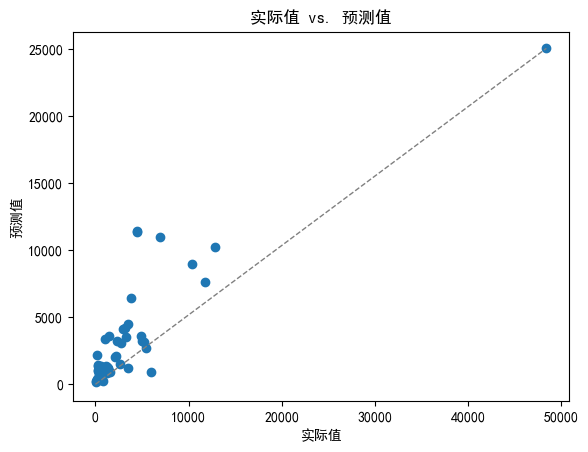

In [22]:
plt.scatter(y_test, y_test_preds_rfr) #预测值和实际值的散点图
plt.plot([0, max(y_test)], [0, max(y_test_preds_rfr)],   color='gray', lw=1, linestyle='--') #绘图
plt.xlabel('实际值') #X轴
plt.ylabel('预测值') #Y轴
plt.title('实际值 vs. 预测值') #标题

这段代码使用`matplotlib.pyplot`（在这里，我们用别名`plt`表示）绘制了一个散点图，用于直观地展示随机森林模型预测的目标变量值（`y_test_preds_rfr`）与测试集中的实际目标变量值（`y_test`）之间的关系。

首先，您使用`plt.scatter()`函数绘制实际值（x轴）与预测值（y轴）的散点图。理想情况下，如果模型预测准确，则大部分点应在对角线上分布。

接下来，您使用`plt.plot()`函数绘制了一条灰色的虚线，表示预测值完全等于实际值的理想情况。在这个图形中，我们绘制线段的起点是`(0, 0)`，终点是`(max(y_test), max(y_test_preds_rfr))`。

然后，您使用`plt.xlabel()`、`plt.ylabel()`和`plt.title()`设置了图形的x轴、y轴标签和标题。

最后，如果您还需要显示这个图，只需要在代码末尾添加`plt.show()`即可。

现在，您可以运行这段代码来生成该散点图，从而直观地评估随机森林模型在测试集上的预测效果。如果预测值和实际值的分布趋向于对角线，则说明模型拟合效果较好。反之，则说明模型在某些情况下可能出现了欠拟合或过拟合。

## 绘制模型性能比较图

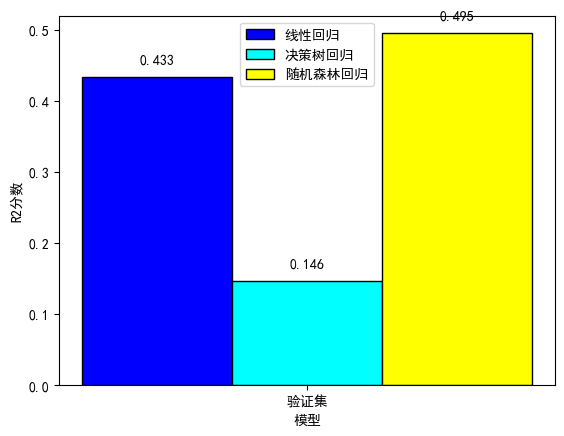

In [23]:
import numpy as np #导入NumPy
  
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i/50+x[i], round(y[i], 3)+0.02, round(y[i], 3), ha = 'center')

# fig = plt.figure()
fig, ax = plt.subplots()    
# ax = fig.add_axes([0,0,1,1])
# scaler = ['StandardScaler', 'MinMaxScaler']

width = 0.25

# bars1 = [r2_score(y_train, model_lr.predict(X_train_norm)),
#          r2_score(y_train, model_lasso.predict(X_train_norm)),
#         r2_score(y_train, model_ridge.predict(X_train_norm))]
bars1 = [r2_score(y_valid, model_lr.predict(X_valid))]
bars2 = [r2_score(y_valid, model_dtr.predict(X_valid))]
bars3 = [r2_score(y_valid, model_rfr.predict(X_valid))]
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + width for x in r1]
r3 = [x + width*2 for x in r1]
 
# Create blue bars
plt.bar(r1, bars1, width = width, color = 'blue', edgecolor = 'black', capsize=7, label='线性回归')
 
# Create cyan bars
plt.bar(r2, bars2, width = width, color = 'cyan', edgecolor = 'black', capsize=7, label='决策树回归')

# Create cyan bars
plt.bar(r3, bars3, width = width, color = 'yellow', edgecolor = 'black', capsize=7, label='随机森林回归')

# general layout
# plt.xticks([r + width/2 for r in range(len(bars1))], ['训练集', '测试集'])
plt.xticks([r + width for r in range(len(bars1))], ['验证集'])
plt.ylabel('R2分数')
plt.xlabel('模型')
plt.legend()


# calling the function to add value labels
addlabels(r1, bars1)
addlabels(r2, bars2)
addlabels(r3, bars3)
 
# Show graphic
plt.show()


这段代码用于生成一个柱状图，展示了3个不同回归模型在验证集（`X_valid`）上的R²分数。为此，首先导入了NumPy库（以别名`np`引入），并定义了一个名为`addlabels`的辅助函数，用于在柱状图的每个柱子上添加对应的数值标签。

接下来，创建了一个新的图形（`fig, ax = plt.subplots()`），并设置柱子的宽度（`width = 0.25`）。

`bars1`、`bars2`和`bars3`分别存储了线性回归模型、决策树回归模型和随机森林回归模型在验证集上的R²分数。为了生成柱状图，应将每组柱状图的x轴位置分开。在这里，我们使用`r1`存储`bars1`的x轴位置，同时生成`r2`和`r3`作为其余两组柱状图的位置。

然后，使用`plt.bar()`函数创建蓝色柱状图（线性回归）、青色柱状图（决策树回归）和黄色柱状图（随机森林回归）。`edgecolor`、`capsize`和`label`参数用于设置每个柱子的边缘颜色、顶部误差线的宽度以及图例标签。

接下来，设置图形的布局，包括x轴刻度标签、y轴标签、x轴标签和图例。使用`plt.xticks()`来设置一个x轴刻度标签，即"验证集"。然后调用`addlabels`函数来为柱状图上的每个柱子添加对应的数值标签。

最后，用`plt.show()`显示生成的图形。这个柱状图直观地展示了3个回归模型在验证集上的R²分数，帮助您比较和评估它们的性能。

# 附录：其他模型演示


根据目前的了解，您的项目是一个回归问题。除了您已经尝试过的线性回归、决策树回归和随机森林回归以外，还有其他一些回归模型可以尝试：

1. 支持向量回归（Support Vector Regression, SVR）：这是一种基于支持向量机（SVM）的回归方法，适用于复杂数据集和高维特征空间。

2. 岭回归（Ridge Regression）：这是线性回归的一种变体，通过对系数加入L2正则化项来降低过拟合风险。

3. Lasso回归：这也是线性回归的一种变体，使用L1正则化来处理具有冗余特征的数据集，可以起到特征选择的作用。

4. 弹性网络回归（Elastic Net Regression）：这是一种同时使用L1和L2正则化的线性回归模型，具有岭回归和Lasso回归的特点。

5. 多层感知器（Multilayer Perceptron, MLP）：这是一种前向传播的人工神经网络。尽管多层感知器被设计用于解决分类问题，但可以通过调整输出层和损失函数来解决回归问题。

6. 梯度提升回归（Gradient Boosting Regression, GBR）：这是一种集成学习方法，通过结合多个弱学习器（如决策树）来提高预测性能。梯度提升方法可以有效处理各种类型的数据。

7. XGBoost（Extreme Gradient Boosting）：这是梯度提升算法的一种高效实现，可以显著降低计算时间，且在许多实际问题中取得了不错的预测表现。

8. LightGBM：这是另一种基于梯度提升树的算法，特别适合处理大规模数据集。

请注意，这些模型可能需要调整一些超参数（例如正则化因子、树的深度和数量等）以获得更好的预测结果。可以通过使用交叉验证（例如网格搜索或随机搜索）寻找最优超参数组合。同时，考虑执行特征工程，例如特征选择、特征缩放和特征转换，来提高模型的预测性能。


## 支持向量回归（SVR）

In [24]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score

svr = SVR(kernel='rbf', C=1)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_valid)
print("R² score (SVR):", r2_score(y_valid, y_pred))


R² score (SVR): -0.10845645320108388


## 岭回归

In [25]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_valid)
print("R² score (Ridge Regression):", r2_score(y_valid, y_pred))


R² score (Ridge Regression): 0.43330221882187736


## Lasso回归

In [26]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_valid)
print("R² score (Lasso Regression):", r2_score(y_valid, y_pred))


R² score (Lasso Regression): 0.4333020286244842


## 弹性网络回归

In [27]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train, y_train)
y_pred = elastic_net.predict(X_valid)
print("R² score (Elastic Net Regression):", r2_score(y_valid, y_pred))


R² score (Elastic Net Regression): 0.4333062646058139


## 多层感知器（MLP）

In [28]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

mlp = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu', max_iter=500)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_valid)
print("R² score (MLP):", r2_score(y_valid, y_pred))


R² score (MLP): 0.5610159617949119


## 梯度提升回归 （GBR）

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

gbr = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_valid)
print("R² score (Gradient Boosting Regression):", r2_score(y_valid, y_pred))


R² score (Gradient Boosting Regression): 0.47357947323047644


## XGboost

In [30]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [31]:
import xgboost as xgb
from sklearn.metrics import r2_score

xgbr = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_valid)
print("R² score (XGBoost):", r2_score(y_valid, y_pred))


R² score (XGBoost): 0.4966638195730979


## LightGBM

In [32]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [33]:
import lightgbm as lgb
from sklearn.metrics import r2_score

lgbr = lgb.LGBMRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
lgbr.fit(X_train, y_train)
y_pred = lgbr.predict(X_valid)
print("R² score (LightGBM):", r2_score(y_valid, y_pred))


R² score (LightGBM): 0.4038648732176583


根据您提供的模型输出结果，以下是每个模型的R²分数评估总结：

1. **SVR模型的R²分数：** -0.10845645320108388
   - 该模型的R²分数为负数，表示该SVR模型在验证集上的拟合效果较差，不能很好地解释目标变量的方差。

2. **Ridge Regression模型的R²分数：** 0.43330221882187736
   - Ridge Regression模型的R²分数为0.4333，表明该模型能够解释目标变量的约43.33%的方差，相对拟合良好。

3. **Lasso Regression模型的R²分数：** 0.4333020286244842
   - Lasso Regression模型的R²分数为0.4333，与Ridge Regression模型的分数相同，说明它们在验证集上的拟合效果相似。

4. **Elastic Net Regression模型的R²分数：** 0.4333062646058139
   - Elastic Net Regression模型的R²分数为0.4333，与Ridge Regression模型和Lasso Regression模型的分数相近，说明该模型在验证集上的拟合效果较好。

5. **MLP模型的R²分数：** 0.5610159617949119
   - MLP模型的R²分数为0.5610，表示该模型能够解释目标变量的约56.10%的方差，相较于其他回归模型，拟合效果更好。

6. **Gradient Boosting Regression模型的R²分数：** 0.47357947323047644
   - Gradient Boosting Regression模型的R²分数为0.4736，表明该模型能够解释目标变量的约47.36%的方差，相对拟合良好。

7. **XGBoost模型的R²分数：** 0.4966638195730979
   - XGBoost模型的R²分数为0.4967，说明该模型可以解释目标变量的约49.67%的方差，相对拟合良好。

8. **LightGBM模型的R²分数：** 0.4038648732176583
   - LightGBM模型的R²分数为0.4039，表明该模型能够解释目标变量的约40.39%的方差，拟合效果较差。

综合来看，根据R²分数评估，可以认为MLP模型和XGBoost模型在这些模型中的拟合能力相对较好，而SVR模型和LightGBM模型的拟合能力较差。然而，为了全面评估这些模型的质量，还建议考虑其他评估指标，并结合模型的训练过程和调优过程进行综合分析。

总体而言，这些模型的结果质量存在一定的差异。MLP模型和XGBoost模型在验证集上表现较好，拟合能力相对较高，而SVR模型和LightGBM模型的拟合能力较差。

针对模型的调优建议，可以考虑以下方面：

1. **特征工程：** 确保数据集中包含与目标变量相关的有意义特征。可以尝试进行特征选择、特征转换、特征组合等方法来优化模型输入的特征。

2. **超参数调优：** 对每个模型尝试不同的超参数组合，并使用交叉验证来评估模型在不同参数下的性能。可以使用网格搜索、随机搜索或贝叶斯优化等技术来辅助超参数调优。

3. **模型集成：** 考虑使用模型集成技术来提升整体性能。例如，可以尝试使用随机森林、梯度提升树或堆叠模型等集成方法来结合多个模型的预测结果。

4. **样本调整：** 检查数据集是否存在类别不平衡或样本偏差的情况。针对不平衡的样本分布，可以使用过采样或欠采样等技术来平衡数据集并改善模型训练效果。

5. **其他模型选择：** 尝试使用其他类型的回归模型，如支持向量回归（SVR）的核参数调优、更复杂的神经网络结构、集成学习中的不同模型等。

最重要的是，持续迭代和优化模型的训练过程。不断尝试不同的想法和方法，并使用合适的评估指标来衡量模型的性能。综合使用上述建议和进一步的实验，可以提高模型的预测质量和性能。